In [12]:
import json
import pandas as pd

In [14]:
%%time
from pymongo import MongoClient

MONGO_HOST= 'mongodb://localhost/twitterdata'
client = MongoClient(MONGO_HOST)
db = client.twitterdata
coll = db.abortolegal

CPU times: user 1.2 ms, sys: 26 µs, total: 1.23 ms
Wall time: 856 µs


In [32]:
%%time
tweets = []
users = {}
cols_tweet = ['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text',
              'posicion', 'favorited', 'retweeted']
cols_user = [
             u'created_at',
             u'description',
             u'favourites_count',
             u'followers_count',
             u'friends_count',
             u'geo_enabled',
             u'id',
             u'lang',
             u'location',
             u'name',
             u'protected',
             u'screen_name',
             u'statuses_count',
             u'time_zone',
             u'verified']

for t in coll.find():
    tr = {c: t[c] for c in cols_tweet}
    tr['user_name'] = t['user']['name']
    tr['user_id'] = t['user']['id']
    tr['original_id'] = t['retweeted_status']['id'] if t['retweeted'] else t['id']
    tweets.append(tr)
    uid = t['user']['id'] 
    if uid not in users:
        users[uid] = {c: t['user'][c] for c in cols_user}

CPU times: user 3min 26s, sys: 2.03 s, total: 3min 29s
Wall time: 3min 28s


In [33]:
%%time
tweets = pd.DataFrame(tweets)
users = pd.DataFrame(users.values())

CPU times: user 4.64 s, sys: 109 ms, total: 4.74 s
Wall time: 4.66 s


In [38]:
%%time
tweets['created_at'] = pd.to_datetime(tweets['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

CPU times: user 4.03 s, sys: 0 ns, total: 4.03 s
Wall time: 4.03 s


In [34]:
users['created_at'] = pd.to_datetime(users['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

In [35]:
tweets_no = tweets[tweets.posicion == 'no']
len(tweets_no)

140325

In [36]:
tweets_si = tweets[tweets.posicion == 'si']
len(tweets_si)

404867

In [39]:
%%time
tweets.groupby([tweets.created_at.dt.date, tweets.posicion])['created_at'].count()

CPU times: user 4.74 s, sys: 35.7 ms, total: 4.78 s
Wall time: 4.73 s


created_at  posicion
2018-06-07  no          15342 
            si          22950 
2018-06-08  no          15771 
            si          30798 
2018-06-09  no          8073  
            si          31084 
2018-06-10  no          31808 
            si          50560 
2018-06-11  no          41941 
            si          59162 
2018-06-12  no          20952 
            si          107945
2018-06-13  no          6438  
            si          101423
2018-06-14  si          945   
Name: created_at, dtype: int64

# Tweets Más retuiteados

In [55]:
# esto es para que pandas muestre el texto completo
pd.set_option('display.max_colwidth', -1)
import re

In [56]:
df = tweets_si[['original_id', 'retweet_count', 'favorite_count', 'full_text']]
# Removemos menciones en RTs
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,original_id,retweet_count,favorite_count
full_text,,,
"Argentina, 1984.\nArgentina, 2018.\n\nDespués de 3 décadas, ¡por fin Argentina hace historia! La cámara de diputados vota…",1007307111225856000,29554,0
Se gritó como un gol de Messi. Emoción. #AbortoLegalYa https://t.co/mRQD3iKfW3,1007307110676344834,22804,0
"""estoy a favor de las 2 vidas, por eso es que voto a favor de la despenalización del aborto"" MIREN LA CARA DE LA DE ABAJ…",1007307100274470912,15117,0
"#AbortoLegalYa - sigan este hilo.\nNO SOY NEUTRAL.\nMi nombre es Cecilia Ousset. Soy católica, médica, especialista en tocogi…",1007306933391560704,14637,0
"#AbortoLegalYa - sigan este hilo.\nNO SOY NEUTRAL.\nMi nombre es Cecilia Ousset. Soy católica, médica, especialista en tocoginecología, madre de cuatros hijos. Trabajo actualmente en el Sistema de Salud privado, aunque me formé y trabajé en el Sistema Público en la Ciudad de Mza.",1004740559234355200,14627,18068
Argentina tiene que avanzar! El aborto existió siempre!\nBasta de muertes en la clandestinidad!\nUn país con mejor educación s…,1007049369378607104,14412,0
"Si no llegamos nosotras, lo van a conseguir ellas. \n#AbortoLegalYa https://t.co/JqjJPkvyAK",1004779457817739264,11329,0
"En las calles, en lxs jóvenes, este debate ya está ganado💚\n#ElFuturoYallego #AbortoSeraLey https://t.co/PAj9oJ7lnY",1007307100937211904,10065,0
Se entiende? #AbortoLegalYa https://t.co/c8UOiE51VV,1005188205069701122,9587,0


In [57]:
df = tweets_no[['original_id', 'retweet_count', 'favorite_count', 'full_text']]
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,original_id,retweet_count,favorite_count
full_text,,,
"APLAUSOS DE PIE para éstos médicos tucumanos que grabaron éste spot contra el ABORTO.\n\n""Estudiamos para cuidar la vida de t…",1007044079606206465,2734,0
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los CO…",1007035801006497792,2459,0
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\nHoy salió el programa grabado. Pasen y vean👇 \n\n#PorElMundo #ArgentinaEsProvida https://t.co/2MU5yGA1oY",1005927050623049729,2458,4302
"APLAUSOS DE PIE para éstos médicos tucumanos que grabaron éste spot contra el ABORTO.\n\n""Estudiamos para cuidar la vida de todos. Si estás pensando en nosotros para practicar abortos, NO CUENTEN CONMIGO"" 👏👏👏\n\nRT que lo vean todos 🇦🇷\n\n#SalvemosLas2Vidas\n#NoAlAborto #SiAlavida https://t.co/Vwd4etkRvt",1005452503721369601,2363,2837
¿Saben qué es lo mejor de los pro-vida? Que somos mayoría en Argentina sin recibir los millones de dólares que los abortis…,1007048309087899648,2160,0
"¿Saben qué es lo mejor de los pro-vida? Que somos mayoría en Argentina sin recibir los millones de dólares que los abortistas han recibido de internacionales de la muerte, como Planned Parenthood, para llevar adelante su campaña mortífera.\n#ArgentinaEsProvida",1006032137538228224,2144,4975
Con Uma decimos: SI A LA VIDA #CuidemosLasDosVidas ❤️❤️ https://t.co/mGfDwWIIWO,1007048280004538368,1990,11816
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que…",1007049964428693504,1970,0
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas",1007028426459533317,1969,4723


## Análisis usuarios

In [59]:
len(users)

191610

In [61]:
users_si = users[users.id.isin(tweets_si.user_id)]
len(users_si)

159419

In [62]:
users_no = users[users.id.isin(tweets_no.user_id)]
len(users_no)

45471

## más activ@s

## Sí

In [53]:
top = tweets_si.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified,n_tweets
113562,2011-07-11 06:26:51,Carnivora --- Endemoniada,7458,1145,1304,True,333236636,es,,Gabriela Martinez,False,gabrielamartf,218414,None,False,552
157611,2010-09-24 02:29:14,No soy lo que hago. Soy infinita ✌️✌️✌️ Nac & Pop,87699,1310,2171,True,194421006,es,"Bragado, Argentina",María Laura P,False,mlaurapratt,79435,None,False,478
109616,2010-06-20 07:36:50,Feminista Médico Psiquiatra Psicodramatista DDHH Peronista Profundamente irrespetuoso con cualquier conducta dominante & gurúes & líderes religiosos,14932,6957,6923,True,157589057,es,"Buenos Aires, Argentina",Enrique Stola,False,Stolae,66582,None,False,454
137418,2013-09-15 14:23:55,Médica especializada en Salud Pública (UBA). Diputada Nacional (M.C). Vivo en #Beccar.,53240,13514,1188,True,1867893876,es,San Isidro,Marcela Durrieu,False,MarcelaDurrieu,130388,None,True,305
66156,2015-01-03 17:24:49,,7713,88,1001,False,2958741387,es,,el paraiso,False,macia753,3765,None,False,305
159676,2013-07-30 10:19:47,.,3609,75,364,False,1632548502,es,Ushuaia. Argentina,Lucia Trebucq,False,luciatre86,2747,None,False,303
162893,2011-05-22 23:33:02,,70158,820,2001,False,303487087,es,"Buenos Aires, Argentina.",Marcia Gomez,False,marciaegomez,79378,None,False,292
60726,2010-02-11 17:51:02,Feminist. Pro-choice. Atheist. Pan.\nWhovian. Jrocker. Manga & J-Fashion lover. Bookworm. Potterhead. Nerd. Fujoshi. Awkward.,4083,95,195,False,113415672,es,Argentina,Xiomara B.,False,Chibixio,1300,None,False,250
73020,2018-02-25 19:18:35,,2272,1905,239,False,967841272659628039,es,"Ciudad Autónoma de Buenos Aires, Argentina",Activa el Congreso,False,activacongreso,2124,None,False,246
188760,2012-09-05 20:13:26,,91,65,199,False,805299080,es,,amariaizquierdo,False,amaria18,1452,None,False,232


## No

In [54]:
top = tweets_no.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified,n_tweets
67948,2016-04-27 01:23:44,,6086,108,566,False,725133295583907840,es,,ÁngelesEsperAspiazú,False,AspiazuEsper,1854,None,False,455
2946,2018-05-23 00:49:48,Provida,2210,127,668,False,999089982227742721,en,Argentina,Gerardo Williams,False,FfErnest,2013,None,False,369
73750,2017-10-18 02:05:50,,3367,13,347,False,920470947987099648,es,,Julucata,False,Julucata2,1321,None,False,316
160354,2018-06-01 01:07:31,,229,36,21,False,1002355930426683392,es,,Pily,False,PuyPilar,1186,None,False,314
18194,2012-02-21 21:13:04,"Silchis, Sil o La Morocha\r\nDe la Pcia de SnJn Arg\nPresidenta de @EclipseFco 🌘\nFans Club Oficial de @LucianoPereyra 💗\nDesde el 14/02/2000\nY vamos por más!!! 💪",18575,448,932,True,499174600,es,San Juan,Silvia Pereira,False,Silchis_ok,31774,None,False,295
189687,2010-09-06 22:27:34,,542,12,84,False,187690240,es,,ariluszy,False,ariluszy,1817,None,False,290
85122,2018-05-06 02:37:44,,983,25,20,False,992956550221369344,en,,Juana,False,juana052018,1813,None,False,274
140355,2018-03-30 16:30:55,,29,12,46,True,979757876452450304,en,,Maria Rives,False,MariaRives4,1488,None,False,272
68669,2013-01-08 23:53:16,"Cantante latina, nacida en Buenos Aires",135,381,1079,True,1072359877,es,Buenos Aires,Yadhira Santamarina,False,yadsantamarina,9418,None,False,272
130944,2015-03-03 05:52:22,34 años Tucumana Madre abogada Provida. B♡stera amante del futbol y lectura. A.C.A.,9595,881,2934,False,3067232547,en,Tucumán,Silvia Bordo,False,Bordo_Silvia,5830,None,False,250


## Fechas de creación de perfiles

In [70]:
%matplotlib inline

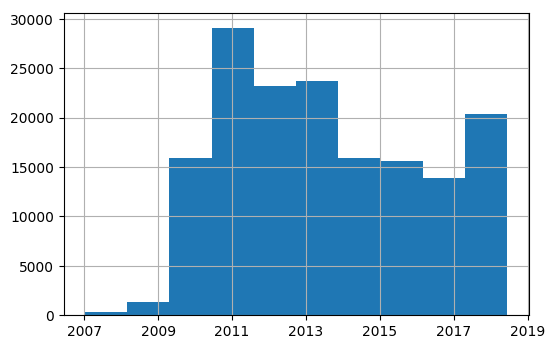

In [71]:
users_si.created_at.hist()

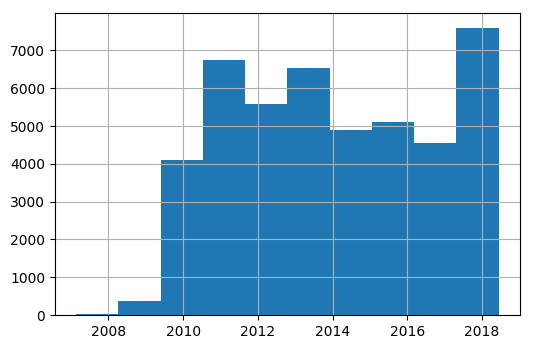

In [72]:
users_no.created_at.hist()

## Cuentas verificadas

In [67]:
users_si.verified.value_counts()

False    158991
True     428   
Name: verified, dtype: int64

In [68]:
users_no.verified.value_counts()

False    45427
True     44   
Name: verified, dtype: int64